# Running TCAV


This notebook walks you through things you need to run TCAV. In high level, you need:

1. **example images in each folder**
 * images for each concept
 * images for the class/labels of interest
 * random images that will be negative examples when learning CAVs (images that probably don't belong to any concepts)
2. **model wrapper**: an instance of  ModelWrapper abstract class (in model.py). This tells TCAV class (tcav.py) how to communicate with your model (e.g., getting internal tensors)
3. **act_generator**: an instance of ActivationGeneratorInterface that tells TCAV class how to load example data and how to get activations from the model



## Requirements

    Install sklearn and PIL before running below!

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import cav as cav
import model as model
import tcav as tcav
import utils as utils
import utils_plot as utils_plot # utils_plot requires matplotlib
import os
import torch
import activation_generator as act_gen
import tensorflow as tf

## Step 1. Store concept and target class images to local folders

and tell TCAV where they are.

**source_dir**: where images of concepts, target class and random images (negative samples when learning CAVs) live. Each should be a sub-folder within this directory.

Note that random image directories can be in any name. In this example, we are using `random500_0`, `random500_1`,.. for an arbitrary reason. 


You need roughly 50-200 images per concept and target class (10-20 pictures also tend to work, but 200 is pretty safe).


**cav_dir**: directory to store CAVs (`None` if you don't want to store)

**target, concept**: names of the target class (that you want to investigate) and concepts (strings) - these are folder names in source_dir

**bottlenecks**: list of bottleneck names (intermediate layers in your model) that you want to use for TCAV. These names are defined in the model wrapper below.



In [10]:
working_dir = '/Users/grantbaum/Desktop/tcav_class_test'
activation_dir =  working_dir + '/activations/'
cav_dir = working_dir + '/cavs/'
source_dir = "/Users/grantbaum/Desktop/image_net_subsets/"
bottlenecks = ['Mixed_5d', 'Conv2d_2a_3x3']
      
utils.make_dir_if_not_exists(activation_dir)
utils.make_dir_if_not_exists(working_dir)
utils.make_dir_if_not_exists(cav_dir)

# this is a regularizer penalty parameter for linear classifier to get CAVs. 
alphas = [0.1]   

target = 'Yorkshire terrier'  
concepts = ["fluffy"]
random_counterpart = 'random500_0'


LABEL_PATH = working_dir + '/imagenet_comp_graph_label_strings.txt'

In [11]:
mymodel = model.InceptionV3Wrapper(LABEL_PATH)

## Step 3. Implement a class that returns activations (maybe with caching!)

Lastly, you will implement a class of the ActivationGenerationInterface which TCAV uses to load example data for a given concept or target, call into your model wrapper and return activations. I pulled out this logic outside of mymodel because this step often takes the longest. By making it modular, you can cache your activations and/or parallelize your computations, as I have done in `ActivationGeneratorBase.process_and_load_activations` in `activation_generator.py`.


The `process_and_load_activations` method of the activation generator must return a dictionary of activations that has concept or target name as  a first key, and the bottleneck name as a second key. So something like:

```python
{concept1: {bottleneck1: [[0.2, 0.1, ....]]},
concept2: {bottleneck1: [[0.1, 0.02, ....]]},
target1: {bottleneck1: [[0.02, 0.99, ....]]}
```


In [12]:
act_generator = act_gen.ImageActivationGenerator(mymodel, source_dir, activation_dir, max_examples=100)

## You are ready to run TCAV!

Let's do it.

**num_random_exp**: number of experiments to confirm meaningful concept direction. TCAV will search for this many folders named `random500_0`, `random500_1`, etc. You can alternatively set the `random_concepts` keyword to be a list of folders of random concepts. Run at least 10-20 for meaningful tests. 

**random_counterpart**: as well as the above, you can optionally supply a single folder with random images as the "positive set" for statistical testing. Reduces computation time at the cost of less reliable random TCAV scores. 


In [14]:
tf.logging.set_verbosity(0)

num_random_exp=2 # folders (random500_0, random500_1)

mytcav = tcav.TCAV(target,
                   concepts,
                   bottlenecks,
                   act_generator,
                   alphas,
                   cav_dir=cav_dir,
                   num_random_exp=num_random_exp)

results = mytcav.run()

['/Users/grantbaum/Desktop/image_net_subsets/fluffy/Labradoodle-Medium-Dogs-that-Dont-Shed.jpg', '/Users/grantbaum/Desktop/image_net_subsets/fluffy/.DS_Store', '/Users/grantbaum/Desktop/image_net_subsets/fluffy/alpaca_animal_bizarre_brown_comical_curly_face_fluffy-1259552.jpg!d.jpeg', '/Users/grantbaum/Desktop/image_net_subsets/fluffy/feature.png', '/Users/grantbaum/Desktop/image_net_subsets/fluffy/13340413.jpg', '/Users/grantbaum/Desktop/image_net_subsets/fluffy/b1c5108ba6c2d85108b29ed32e45132a--snowball-too-cute.jpg', '/Users/grantbaum/Desktop/image_net_subsets/fluffy/13340403_f1024.jpg', '/Users/grantbaum/Desktop/image_net_subsets/fluffy/Back-View-of-Short-Curly-Hairstyle-for-Women.jpg', '/Users/grantbaum/Desktop/image_net_subsets/fluffy/Dog-Dog_Guide-A_white_curly_coated_Komondor_lying_down_outside.jpg', '/Users/grantbaum/Desktop/image_net_subsets/fluffy/bunny2-1.jpg', '/Users/grantbaum/Desktop/image_net_subsets/fluffy/Curly hair dogs picture of black toy poodle puppy standing on t

Class = Yorkshire terrier
  Concept = fluffy
    Bottleneck = Mixed_5d. TCAV Score = 0.32 (+- 0.02), random was 0.50 (+- 0.15). p-val = 0.369 (not significant)
    Bottleneck = Conv2d_2a_3x3. TCAV Score = 0.50 (+- 0.10), random was 0.57 (+- 0.02). p-val = 0.543 (not significant)


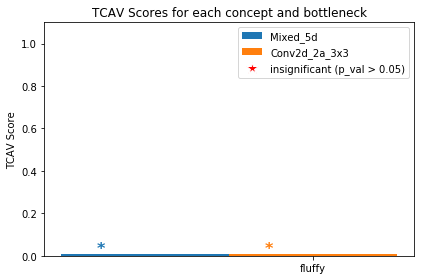

In [15]:
utils_plot.plot_results(results, num_random_exp=num_random_exp)

# Result
## Concept = Fluffy
    Concept was taken from a variety of pictures of fluffy horses, alpacas, dogs, and humans with hair that is wavy and fluffy in a way similar to a yorkshire terrier.
## Target = Yorkshire Terrier
    Goal is to see how much the concept of fluffiness influences the prediction of yorkshire terriers. I think to a human a yorkshier terrier's hair quality is unique and at least relatively symbolic of the breed of dog however the concept of fluffy hair is not exclusive to this breed or dogs as a whole
    
I dont exepect this to have a small p-value because it was difficult to capture the concept of fluffy hair. Fluffy is a fairly ambigious concept. Therefore some of my examples are more curly type of fluff while others are closer to what is seen on a yorkshire terrier. 

Still very low significance level so maybe concept wasn't precise enough?